In [30]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
from peft import PeftModel
from sklearn.metrics import (
    classification_report,
    multilabel_confusion_matrix,
    hamming_loss,
    jaccard_score,
    accuracy_score,
    precision_recall_fscore_support,
    f1_score
)
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset
import os
import ast

In [31]:
# ============================================
# LOAD MODEL AND ARTIFACTS
# ============================================
print("Loading model and artifacts...")

# Define model directory
run_dir = "./experiments/lr=0.0005_ep=8"

# 1. Load configuration
with open(os.path.join(run_dir, "model_config.pkl"), "rb") as f:
    config_info = pickle.load(f)
NUM_LABELS = config_info["num_labels"]
MODEL_NAME = config_info["model_name"]
GENRES = config_info["genres"]
print(f"✓ Config loaded - {NUM_LABELS} genres")

# 2. Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    os.path.join(run_dir, "saved_tokenizer"),
    trust_remote_code=True
)
tokenizer.pad_token = tokenizer.eos_token
print("✓ Tokenizer loaded")

# 3. Load MultiLabelBinarizer
with open(os.path.join(run_dir, "mlb.pkl"), "rb") as f:
    mlb = pickle.load(f)
print("✓ MultiLabelBinarizer loaded")

# 4. Rebuild model architecture
class QwenForMultiLabelClassification(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(
            base_model.config.hidden_size,
            num_labels
        )
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        last_hidden = outputs.last_hidden_state[:, -1, :]
        logits = self.classifier(last_hidden)
        loss = None
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
        return {"loss": loss, "logits": logits}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load base model + LoRA
base_model = AutoModel.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)

base_model = PeftModel.from_pretrained(
    base_model,
    os.path.join(run_dir, "saved_model")
)

# Build full model
model = QwenForMultiLabelClassification(base_model, NUM_LABELS)

# Load classifier head (still on CPU at this point)
classifier_state = torch.load(
    os.path.join(run_dir, "saved_model", "classifier_head.pt"),
    map_location="cpu"
)
model.classifier.load_state_dict(classifier_state["classifier"])

# 🔥 NOW move EVERYTHING to GPU
model.to(device)
model.eval()

# ============================================
# LOAD TEST DATA
# ============================================
print("\nLoading test data...")

# Load the cleaned dataset
DATA_PATH = "imdb_overview_genres_clean.csv"

df = pd.read_csv(DATA_PATH)
# df["genres"] = df["genres"].apply(lambda x: x.split("|"))
df["genres"] = df["genres"].str.replace("|", ",")
df["genres"] = df["genres"].str.replace("'",'"')
df["genres"] = df["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


# Rebuild the same train/test split
from sklearn.model_selection import train_test_split
labels = mlb.transform(df["genres"])
X_train, X_temp, y_train, y_temp = train_test_split(
    df["overview"], labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
print(f"✓ Test set size: {len(X_test)}")

Loading model and artifacts...
✓ Config loaded - 23 genres
✓ Tokenizer loaded
✓ MultiLabelBinarizer loaded

Loading test data...
✓ Test set size: 750


In [34]:
# ============================================
# 1. GET PREDICTIONS ON TEST SET
# ============================================
print("\nGenerating predictions on test set...")

def get_predictions_from_model(model, texts, true_labels, batch_size=16):
    """Get model predictions for a list of texts"""
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_logits = []
    total_batches = (len(texts) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size].tolist()
            
            # Use dynamic padding instead of max_length padding
            inputs = tokenizer(
                batch_texts,
                truncation=True,
                padding="max_length",
                max_length=128,  
                return_tensors="pt"
            )
            
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"]
            )
            
            all_logits.append(outputs["logits"].cpu())
            
            # Progress indicator
            if (i // batch_size + 1) % 10 == 0:
                print(f"  Processed {i // batch_size + 1}/{total_batches} batches...")
    
    logits = torch.cat(all_logits, dim=0).numpy()
    probs = torch.sigmoid(torch.from_numpy(logits)).numpy()
    pred_labels = (probs > 0.5).astype(int)
    
    return pred_labels, true_labels, probs

pred_labels, true_labels, probs = get_predictions_from_model(
    model, X_test, y_test, batch_size=16  # Match training batch size
)
print("Predictions shape:", pred_labels.shape)
print("True labels shape:", true_labels.shape)


Generating predictions on test set...
  Processed 10/47 batches...
  Processed 20/47 batches...
  Processed 30/47 batches...
  Processed 40/47 batches...
Predictions shape: (750, 23)
True labels shape: (750, 23)


In [35]:
# ============================================
# 2. OVERALL METRICS
# ============================================

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)

# Subset Accuracy (exact match)
subset_accuracy = accuracy_score(true_labels, pred_labels)
print(f"Subset Accuracy (Exact Match): {subset_accuracy:.4f}")

# Hamming Loss
hamming = hamming_loss(true_labels, pred_labels)
print(f"Hamming Loss: {hamming:.4f}")

# Jaccard Score
jaccard = jaccard_score(true_labels, pred_labels, average='samples')
print(f"Jaccard Score (Samples): {jaccard:.4f}")

# Precision, Recall, F1
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    true_labels, pred_labels, average='micro'
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    true_labels, pred_labels, average='macro'
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    true_labels, pred_labels, average='weighted'
)

print(f"\nMicro Averages:")
print(f"  Precision: {precision_micro:.4f}")
print(f"  Recall: {recall_micro:.4f}")
print(f"  F1-Score: {f1_micro:.4f}")

print(f"\nMacro Averages:")
print(f"  Precision: {precision_macro:.4f}")
print(f"  Recall: {recall_macro:.4f}")
print(f"  F1-Score: {f1_macro:.4f}")

print(f"\nWeighted Averages:")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall: {recall_weighted:.4f}")
print(f"  F1-Score: {f1_weighted:.4f}")



OVERALL METRICS
Subset Accuracy (Exact Match): 0.1200
Hamming Loss: 0.0886
Jaccard Score (Samples): 0.4334

Micro Averages:
  Precision: 0.6055
  Recall: 0.5185
  F1-Score: 0.5586

Macro Averages:
  Precision: 0.4652
  Recall: 0.3576
  F1-Score: 0.3916

Weighted Averages:
  Precision: 0.5981
  Recall: 0.5185
  F1-Score: 0.5508


c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true no

In [36]:
# ============================================
# 3. PER-CLASS METRICS
# ============================================

print("\n" + "="*60)
print("PER-CLASS METRICS")
print("="*60)

# Get per-class metrics
precision_per_class, recall_per_class, f1_per_class, support_per_class = \
    precision_recall_fscore_support(true_labels, pred_labels, average=None)

# Create DataFrame for better visualization
per_class_df = pd.DataFrame({
    'Genre': mlb.classes_,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class.astype(int)
})

per_class_df = per_class_df.sort_values('F1-Score', ascending=False)
print(per_class_df.to_string(index=False))

# Save to CSV
per_class_df.to_csv('per_class_metrics.csv', index=False)
print("\nPer-class metrics saved to 'per_class_metrics.csv'")


PER-CLASS METRICS
     Genre  Precision   Recall  F1-Score  Support
   Western   0.619048 0.812500  0.702703       16
     Drama   0.733516 0.652812  0.690815      409
    Action   0.662162 0.617647  0.639130      238
    Horror   0.645161 0.560748  0.600000      107
     Crime   0.642424 0.554974  0.595506      191
    Comedy   0.549296 0.582090  0.565217      201
 Adventure   0.594340 0.473684  0.527197      133
    Sci-Fi   0.574468 0.457627  0.509434       59
   Romance   0.512195 0.506024  0.509091       83
     Sport   0.666667 0.400000  0.500000       15
     Music   0.600000 0.428571  0.500000       14
  Thriller   0.472727 0.366197  0.412698      142
   Mystery   0.431373 0.323529  0.369748       68
 Biography   0.666667 0.240000  0.352941       25
   History   0.357143 0.263158  0.303030       19
    Family   0.303030 0.277778  0.289855       36
 Animation   0.384615 0.227273  0.285714       22
       War   0.363636 0.235294  0.285714       17
   Fantasy   0.421053 0.177778 

c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\OneDrive\Documents\tugas uii\semester 2\analitik_teks\Tugas_akhir\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true no


Visualization saved to 'genre_classification_metrics.png'


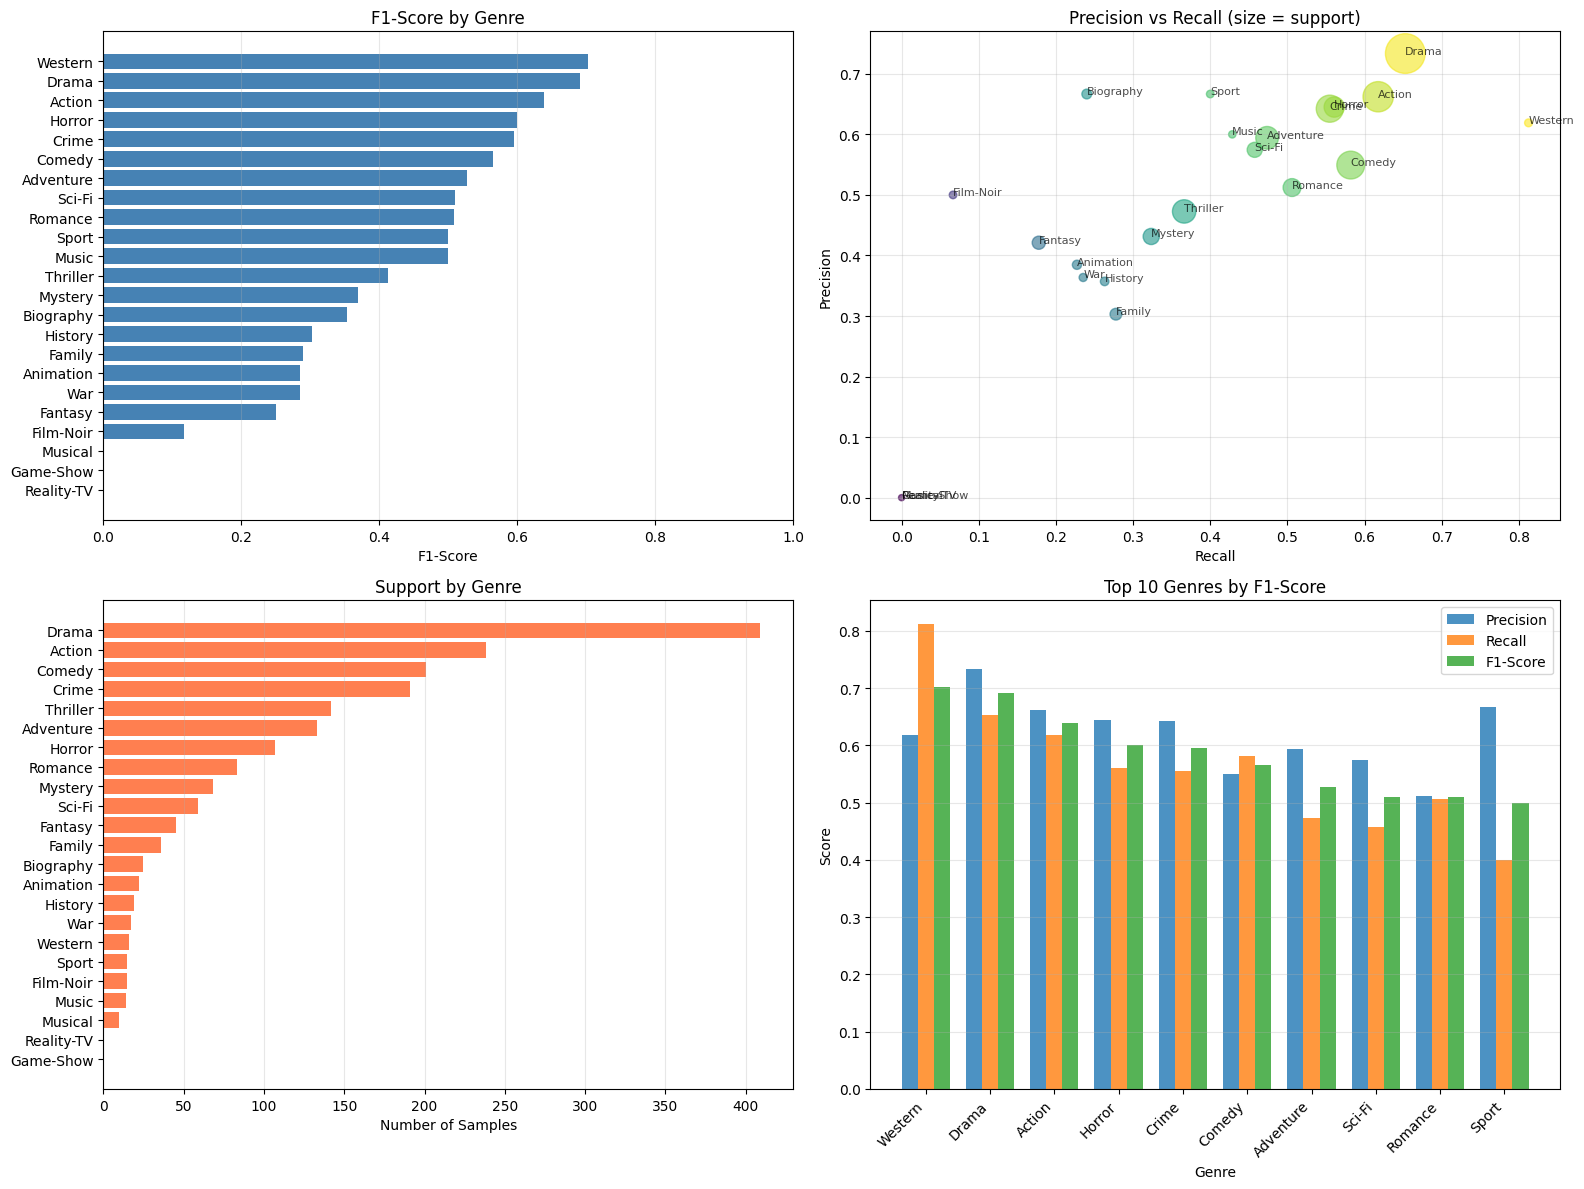

In [37]:
# ============================================
# 4. VISUALIZATION - Performance by Genre
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: F1-Score by Genre
ax1 = axes[0, 0]
per_class_df_sorted = per_class_df.sort_values('F1-Score')
ax1.barh(per_class_df_sorted['Genre'], per_class_df_sorted['F1-Score'], color='steelblue')
ax1.set_xlabel('F1-Score')
ax1.set_title('F1-Score by Genre')
ax1.set_xlim([0, 1])
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Precision vs Recall by Genre
ax2 = axes[0, 1]
ax2.scatter(per_class_df['Recall'], per_class_df['Precision'], 
            s=per_class_df['Support']*2, alpha=0.6, c=per_class_df['F1-Score'], 
            cmap='viridis')
for idx, row in per_class_df.iterrows():
    ax2.annotate(row['Genre'], (row['Recall'], row['Precision']), 
                fontsize=8, alpha=0.7)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision vs Recall (size = support)')
ax2.grid(alpha=0.3)

# Plot 3: Support by Genre
ax3 = axes[1, 0]
per_class_df_support = per_class_df.sort_values('Support')
ax3.barh(per_class_df_support['Genre'], per_class_df_support['Support'], color='coral')
ax3.set_xlabel('Number of Samples')
ax3.set_title('Support by Genre')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: All metrics comparison (top 10 genres by F1)
ax4 = axes[1, 1]
top_10 = per_class_df.nlargest(10, 'F1-Score')
x = np.arange(len(top_10))
width = 0.25
ax4.bar(x - width, top_10['Precision'], width, label='Precision', alpha=0.8)
ax4.bar(x, top_10['Recall'], width, label='Recall', alpha=0.8)
ax4.bar(x + width, top_10['F1-Score'], width, label='F1-Score', alpha=0.8)
ax4.set_xlabel('Genre')
ax4.set_ylabel('Score')
ax4.set_title('Top 10 Genres by F1-Score')
ax4.set_xticks(x)
ax4.set_xticklabels(top_10['Genre'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('genre_classification_metrics.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to 'genre_classification_metrics.png'")
plt.show()

Confusion matrices saved to 'confusion_matrices.png'


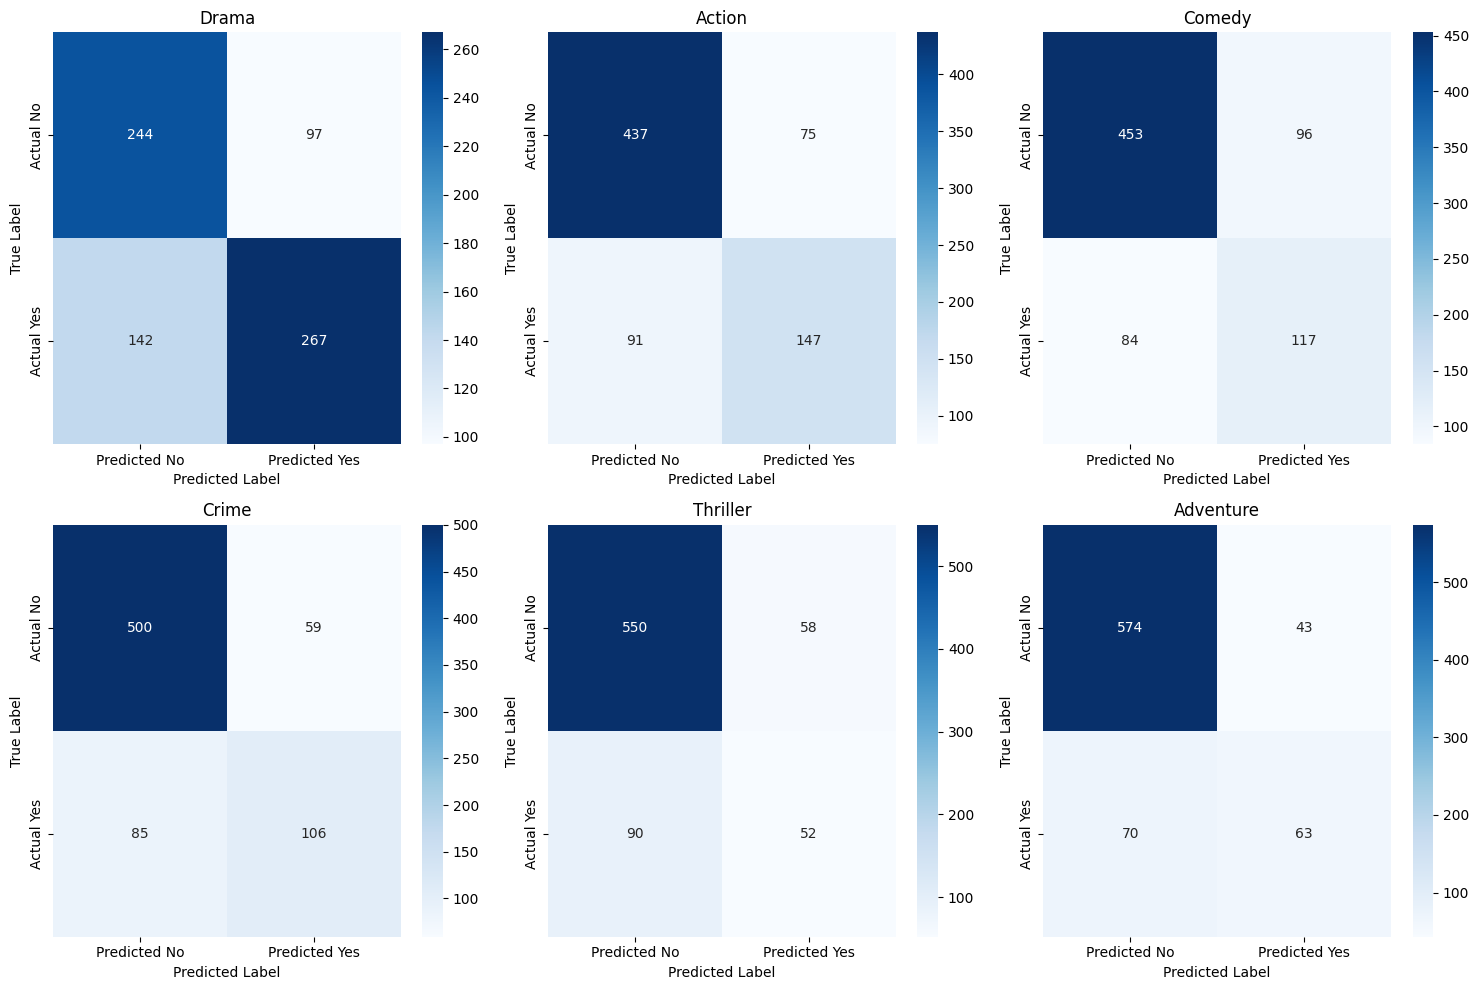

In [38]:
# ============================================
# 5. CONFUSION MATRIX (for multi-label)
# ============================================

# Multi-label confusion matrices (one per class)
cm_multi = multilabel_confusion_matrix(true_labels, pred_labels)

# Plot confusion matrices for top 6 genres by support
top_genres_idx = per_class_df.nlargest(6, 'Support').index.tolist()
top_genre_names = per_class_df.loc[top_genres_idx, 'Genre'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (idx, genre) in enumerate(zip(top_genres_idx, top_genre_names)):
    genre_idx = np.where(mlb.classes_ == genre)[0][0]
    cm = cm_multi[genre_idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    axes[i].set_title(f'{genre}')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Confusion matrices saved to 'confusion_matrices.png'")
plt.show()



PREDICTION DISTRIBUTION
Label distribution saved to 'label_distribution.png'


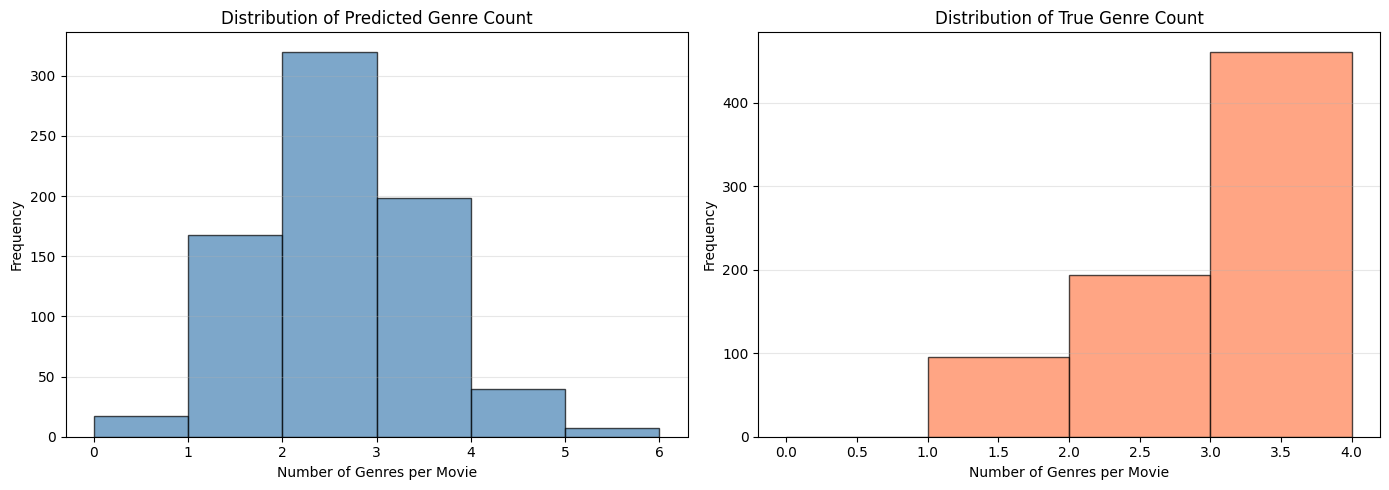


Average predicted genres per movie: 2.13
Average true genres per movie: 2.49


In [39]:
# ============================================
# 6. PREDICTION DISTRIBUTION ANALYSIS
# ============================================

print("\n" + "="*60)
print("PREDICTION DISTRIBUTION")
print("="*60)

# Number of labels per sample
pred_counts = pred_labels.sum(axis=1)
true_counts = true_labels.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted labels distribution
axes[0].hist(pred_counts, bins=range(0, max(pred_counts)+2), 
             alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Genres per Movie')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Predicted Genre Count')
axes[0].grid(axis='y', alpha=0.3)

# True labels distribution
axes[1].hist(true_counts, bins=range(0, max(true_counts)+2), 
             alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Genres per Movie')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of True Genre Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')
print("Label distribution saved to 'label_distribution.png'")
plt.show()

print(f"\nAverage predicted genres per movie: {pred_counts.mean():.2f}")
print(f"Average true genres per movie: {true_counts.mean():.2f}")

In [40]:
# ============================================
# 7. SAMPLE PREDICTIONS
# ============================================

print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Show 5 random examples
sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    text = X_test.iloc[idx]
    true_genres = [mlb.classes_[i] for i, val in enumerate(true_labels[idx]) if val == 1]
    pred_genres = [mlb.classes_[i] for i, val in enumerate(pred_labels[idx]) if val == 1]
    
    print(f"\nText: {text[:200]}...")
    print(f"True Genres: {', '.join(true_genres)}")
    print(f"Predicted Genres: {', '.join(pred_genres)}")
    print("-" * 60)



SAMPLE PREDICTIONS

Text: A young German boy in the Hitler Youth whose hero and imaginary friend is the country's dictator is shocked to discover that his mother is hiding a Jewish girl in their home....
True Genres: Comedy, Drama, War
Predicted Genres: Drama
------------------------------------------------------------

Text: In 2016 BC, a kind farmer leads an uprising in the city of Mohenjo Daro....
True Genres: Action, Adventure, Drama
Predicted Genres: Action, Adventure, Drama, History
------------------------------------------------------------

Text: Follows the lives of the Charles family as they deal with themes of family legacy and more, in deciding what to do with an heirloom, the family piano....
True Genres: Drama, Music
Predicted Genres: Comedy, Drama, Musical, Romance, War
------------------------------------------------------------

Text: The ghost of a dead husband haunts his wife as she moves back to their house in NYC. She's about to marry an egyptologist there....
Tr

In [41]:
# ============================================
# 8. SAVE COMPREHENSIVE REPORT
# ============================================

with open('evaluation_report.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("GENRE CLASSIFICATION - EVALUATION REPORT\n")
    f.write("="*60 + "\n\n")
    
    f.write("OVERALL METRICS\n")
    f.write("-"*60 + "\n")
    f.write(f"Subset Accuracy (Exact Match): {subset_accuracy:.4f}\n")
    f.write(f"Hamming Loss: {hamming:.4f}\n")
    f.write(f"Jaccard Score: {jaccard:.4f}\n\n")
    
    f.write(f"Micro Averages:\n")
    f.write(f"  Precision: {precision_micro:.4f}\n")
    f.write(f"  Recall: {recall_micro:.4f}\n")
    f.write(f"  F1-Score: {f1_micro:.4f}\n\n")
    
    f.write(f"Macro Averages:\n")
    f.write(f"  Precision: {precision_macro:.4f}\n")
    f.write(f"  Recall: {recall_macro:.4f}\n")
    f.write(f"  F1-Score: {f1_macro:.4f}\n\n")
    
    f.write(f"Weighted Averages:\n")
    f.write(f"  Precision: {precision_weighted:.4f}\n")
    f.write(f"  Recall: {recall_weighted:.4f}\n")
    f.write(f"  F1-Score: {f1_weighted:.4f}\n\n")
    
    f.write("="*60 + "\n")
    f.write("PER-CLASS METRICS\n")
    f.write("="*60 + "\n\n")
    f.write(per_class_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("="*60 + "\n")
    f.write("PREDICTION STATISTICS\n")
    f.write("="*60 + "\n")
    f.write(f"Average predicted genres per movie: {pred_counts.mean():.2f}\n")
    f.write(f"Average true genres per movie: {true_counts.mean():.2f}\n")

print("\nComprehensive report saved to 'evaluation_report.txt'")
print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  - evaluation_report.txt")
print("  - per_class_metrics.csv")
print("  - genre_classification_metrics.png")
print("  - confusion_matrices.png")
print("  - label_distribution.png")


Comprehensive report saved to 'evaluation_report.txt'

EVALUATION COMPLETE!

Generated files:
  - evaluation_report.txt
  - per_class_metrics.csv
  - genre_classification_metrics.png
  - confusion_matrices.png
  - label_distribution.png
